## Project: Yantra Hack 2023
## Model 2: Demand Forecasting : Future Volume Analysis And Prediction

## Load Python Packages and Access Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from math import sqrt
from numpy import concatenate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## Collection of Data

In [2]:
demo = pd.read_csv('../input/train_OwBvO8W/demographics.csv')
print(demo.shape)
demo.head()

(60, 3)


,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_05,3044268,182944
1,Agency_02,3137874,240809
2,Agency_55,2025793,238553
3,Agency_53,1729177,111048
4,Agency_50,2057678,144594


In [3]:
event = pd.read_csv('../input/train_OwBvO8W/event_calendar.csv')
print(event.shape)
event['YearMonth']  = pd.to_datetime(event['YearMonth'],format='%Y%m')
event.head()

(61, 13)


,YearMonth,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,2013-01-01,0,0,1,0,0,0,0,0,0,0,0,0
1,2013-02-01,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-03-01,1,1,0,0,0,0,0,0,0,0,0,1
3,2013-04-01,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-05-01,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
historical = pd.read_csv('../input/train_OwBvO8W/historical_volume.csv')
print(historical.shape)
historical['YearMonth'] = pd.to_datetime(historical['YearMonth'],format='%Y%m')
historical.head()

(21000, 4)


,Agency,SKU,YearMonth,Volume
0,Agency_22,SKU_01,2013-01-01,52.2720
1,Agency_22,SKU_02,2013-01-01,110.7000
2,Agency_58,SKU_23,2013-01-01,0.0000
3,Agency_48,SKU_07,2013-01-01,28.3200
4,Agency_22,SKU_05,2013-01-01,238.5387


In [5]:
soda = pd.read_csv('../input/train_OwBvO8W/industry_soda_sales.csv')
print(soda.shape)
soda['YearMonth'] = pd.to_datetime(soda['YearMonth'],format='%Y%m')
soda.head()

(60, 2)


,YearMonth,Soda_Volume
0,2013-01-01,718394219
1,2013-02-01,753938444
2,2013-03-01,892192092
3,2013-04-01,838099501
4,2013-05-01,864420003


In [6]:
industry = pd.read_csv('../input/train_OwBvO8W/industry_volume.csv')
print(industry.shape)
industry['YearMonth'] = pd.to_datetime(industry['YearMonth'],format='%Y%m')
industry.head()

(60, 2)


,YearMonth,Industry_Volume
0,2013-01-01,492612703
1,2013-02-01,431937346
2,2013-03-01,509281531
3,2013-04-01,532390389
4,2013-05-01,551755254


In [7]:
price = pd.read_csv('../input/train_OwBvO8W/price_sales_promotion.csv')
print(price.shape)
price['YearMonth'] = pd.to_datetime(price['YearMonth'],format='%Y%m')
price.head()

(21000, 6)


,Agency,SKU,YearMonth,Price,Sales,Promotions
0,Agency_01,SKU_01,2013-01-01,1141.500000,1033.432731,108.067269
1,Agency_01,SKU_01,2013-02-01,1141.500000,1065.417195,76.082805
2,Agency_01,SKU_01,2013-03-01,1179.345820,1101.133633,78.212187
3,Agency_01,SKU_01,2013-04-01,1226.687500,1138.283357,88.404143
4,Agency_01,SKU_01,2013-05-01,1230.331104,1148.969634,81.361470


In [8]:
weather = pd.read_csv('../input/train_OwBvO8W/weather.csv')
print(weather.shape)
weather['YearMonth'] = pd.to_datetime(weather['YearMonth'],format='%Y%m')
weather.head()

(3600, 3)


,YearMonth,Agency,Avg_Max_Temp
0,2013-01-01,Agency_01,17.072
1,2013-02-01,Agency_01,19.984
2,2013-03-01,Agency_01,24.600
3,2013-04-01,Agency_01,27.532
4,2013-05-01,Agency_01,29.396


## Pivot Element: SKU - Stock Keeping Units 
## Merge Data Related To SKU And Agency

In [9]:
sku = historical.merge(price,on=['Agency','SKU','YearMonth'],how='left')
sku = sku.merge(soda,on=['YearMonth'],how='left')
sku = sku.merge(industry,on='YearMonth',how='left')
sku = sku.merge(event,on=['YearMonth'],how='left')
print(sku.shape)
sku.head()

(21000, 21)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
sku.describe()

,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
count,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.000000,21000.000000
mean,1492.403982,1451.536344,1267.347450,184.374146,8.512000e+08,5.439214e+08,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.016667,0.0,0.0,0.083333,0.083333
std,2711.496882,683.362417,587.757323,257.469968,7.824340e+07,6.288022e+07,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.128022,0.0,0.0,0.276392,0.276392
min,0.000000,0.000000,-3121.690141,0.000000,6.964015e+08,4.130518e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,8.272388,1311.547158,1178.365653,54.935108,7.890880e+08,5.090553e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,158.436000,1495.174592,1324.695705,138.307225,8.649196e+08,5.512000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
75%,1774.793475,1725.652080,1517.311427,272.298630,9.005551e+08,5.893715e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
max,22526.610000,19166.625000,4925.404000,19166.625000,1.049869e+09,6.700157e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000


In [11]:
agency = weather.merge(demo,on=['Agency'],how='left')
print(agency.shape)
agency.head()

(3600, 5)


,YearMonth,Agency,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,2013-01-01,Agency_01,17.072,153733,120207
1,2013-02-01,Agency_01,19.984,153733,120207
2,2013-03-01,Agency_01,24.600,153733,120207
3,2013-04-01,Agency_01,27.532,153733,120207
4,2013-05-01,Agency_01,29.396,153733,120207


In [12]:
agency.describe()

,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
count,3600.000000,3.600000e+03,3600.000000
mean,28.722767,9.367166e+05,148119.333333
std,4.021126,9.131855e+05,50188.108577
min,16.731034,1.227100e+04,90240.000000
25%,25.581118,5.034000e+04,106160.750000
50%,28.648529,6.473045e+05,129333.000000
75%,31.676744,1.719314e+06,204560.750000
max,45.290476,3.137874e+06,247220.000000


## Merge YearMonth and Agency

In [13]:
df = sku.merge(agency,on=['YearMonth','Agency'],how='left')
print(df.shape)
df.head()

(21000, 24)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110


In [14]:
df = pd.get_dummies(df, columns= ['SKU'], dummy_na= False)
df.head()

,Agency,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
0,Agency_22,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agency_22,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agency_58,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Agency_48,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agency_22,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df.describe()

,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
count,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,1451.536344,1267.347450,184.374146,8.512000e+08,5.439214e+08,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.016667,0.0,0.0,0.083333,0.083333,28.612404,1.045065e+06,151073.494286,0.148571,0.148571,0.162857,0.165714,0.148571,0.011429,0.040000,0.020000,0.008571,0.002857,0.011429,0.005714,0.022857,0.011429,0.005714,0.028571,0.005714,0.022857,0.002857,0.002857,0.002857,0.002857,0.002857,0.008571,0.005714
std,2711.496882,683.362417,587.757323,257.469968,7.824340e+07,6.288022e+07,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.128022,0.0,0.0,0.276392,0.276392,3.972833,9.291926e+05,50409.593114,0.355674,0.355674,0.369244,0.371833,0.355674,0.106294,0.195964,0.140003,0.092187,0.053377,0.106294,0.075378,0.149452,0.106294,0.075378,0.166603,0.075378,0.149452,0.053377,0.053377,0.053377,0.053377,0.053377,0.092187,0.075378
min,0.000000,0.000000,-3121.690141,0.000000,6.964015e+08,4.130518e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,16.731034,1.227100e+04,90240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.272388,1311.547158,1178.365653,54.935108,7.890880e+08,5.090553e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,25.374816,6.018900e+04,110057.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,158.436000,1495.174592,1324.695705,138.307225,8.649196e+08,5.512000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,28.479272,1.232242e+06,131411.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1774.793475,1725.652080,1517.311427,272.298630,9.005551e+08,5.893715e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,31.568405,1.729177e+06,206553.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22526.610000,19166.625000,4925.404000,19166.625000,1.049869e+09,6.700157e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,45.290476,3.137874e+06,247220.000000,1.000000,1.000

In [16]:
train_df = df.drop(columns=['Price','Sales','Promotions'])
train_df.set_index('YearMonth',inplace=True)
train_df.head()

,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_22,52.2720,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,110.7000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_58,0.0000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,Agency_48,28.3200,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,238.5387,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Testing Dataset

In [17]:
test = pd.read_csv('../input/test_8uviCCm/volume_forecast.csv')
print(test.shape)
test.head()

(1450, 3)


,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN
2,Agency_24,SKU_02,NaN
3,Agency_40,SKU_06,NaN
4,Agency_42,SKU_32,NaN


In [18]:
n_date = len(train_df.index.unique())
tes4 = pd.date_range(start='1/1/2013', end='31/12/2017',freq='M')
tes3 = list(tes4)*len(test)
tes1 = list(test.Agency)*len(tes4)
tes2 = list(test.SKU)*len(tes4)

In [19]:
test_df = pd.DataFrame({'Agency':tes1,'SKU':tes2,'Volume':np.nan})
test_df.sort_values(['Agency','SKU'],inplace=True,ascending=False)
test_df.reset_index(inplace=True,drop=True)
test_df.loc[:,'YearMonth'] = tes3
test_df['YearMonth'] = test_df['YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(test_df.shape)
test_df.head()

(87000, 4)


,Agency,SKU,Volume,YearMonth
0,Agency_60,SKU_34,NaN,2013-01-01
1,Agency_60,SKU_34,NaN,2013-02-01
2,Agency_60,SKU_34,NaN,2013-03-01
3,Agency_60,SKU_34,NaN,2013-04-01
4,Agency_60,SKU_34,NaN,2013-05-01


In [20]:
test_df = test_df.merge(weather,on=['YearMonth','Agency'],how='left')
test_df = test_df.merge(demo,on='Agency',how='left')
test_df = test_df.merge(industry,on='YearMonth',how='left')
test_df = test_df.merge(soda,on=['YearMonth'],how='left')
test_df = test_df.merge(event,on=['YearMonth'],how='left')
test_df = pd.get_dummies(test_df, columns= ['SKU'], dummy_na= False)
test_df.set_index('YearMonth',inplace=True)
test_df = test_df[train_df.columns]
print(test_df.shape)
test_df.head()

(87000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Preparation Of Demand Forecasting Prediction Data

In [21]:
tes = ['Agency_06','Agency_14']*len(price.SKU.unique())*len(tes4)
tes.sort()
tes5 = list(price.SKU.unique())*2*len(tes4)
df_agen = pd.DataFrame({'Agency':tes,'SKU':tes5,'YearMonth':np.NaN,'Volume':np.NaN})
df_agen.sort_values(['Agency','SKU'],inplace=True)
df_agen.loc[:,'YearMonth'] = list(tes4)*2*25
df_agen.loc[:,'YearMonth'] = df_agen.loc[:,'YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(df_agen.shape)
df_agen.head()

(3000, 4)


,Agency,SKU,YearMonth,Volume
0,Agency_06,SKU_01,2013-01-01,NaN
25,Agency_06,SKU_01,2013-02-01,NaN
50,Agency_06,SKU_01,2013-03-01,NaN
75,Agency_06,SKU_01,2013-04-01,NaN
100,Agency_06,SKU_01,2013-05-01,NaN


In [22]:
df_agen = df_agen.merge(weather,on=['YearMonth','Agency'],how='left')
df_agen = df_agen.merge(demo,on='Agency',how='left')
df_agen = df_agen.merge(industry,on='YearMonth',how='left')
df_agen = df_agen.merge(soda,on=['YearMonth'],how='left')
df_agen = df_agen.merge(event,on=['YearMonth'],how='left')
df_agen = pd.get_dummies(df_agen, columns= ['SKU'], dummy_na= False)
df_agen.set_index('YearMonth',inplace=True)
df_agen = df_agen[train_df.columns]
print(df_agen.shape)
df_agen.head()

(3000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Null and Missing Values 

In [23]:
# find missing values by col
def missing_values_table(df):
        # total
        mis_val = df.isnull().sum()
        
        # percentage when compared to the total missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # tabulate
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # rename
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # sort table
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # summary statistics
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
# find stats of missing values
missing_values = missing_values_table(train_df)

Your selected dataframe has 44 columns.
There are 0 columns that have missing values.


In [25]:
# find stats of missing values
missing_values = missing_values_table(test_df)
missing_values.head()

Your selected dataframe has 44 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Volume,87000,100.0


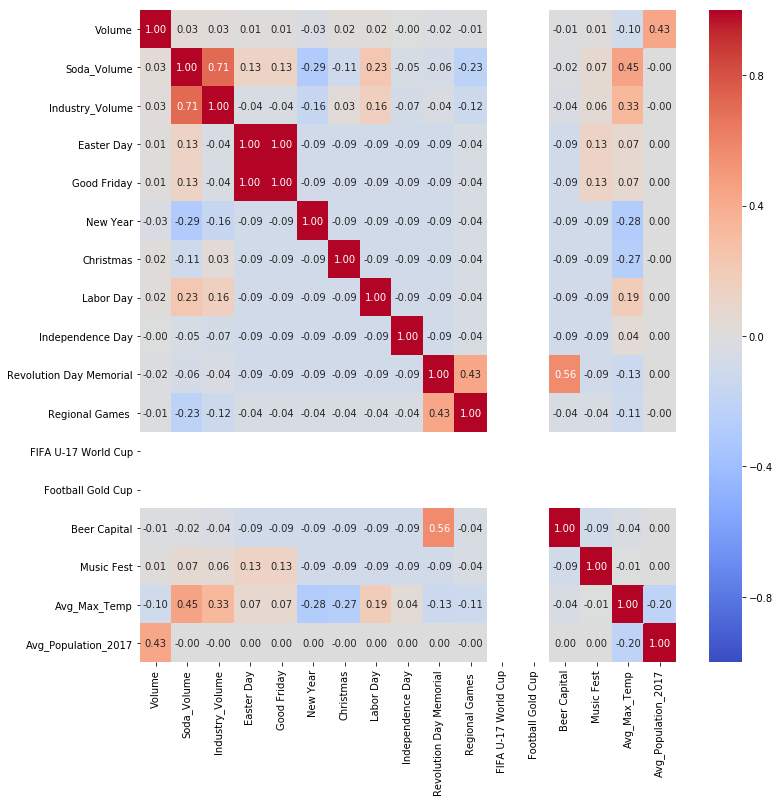

In [26]:
# find correlation between the features
corr = train_df[train_df.columns[:18]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,vmin=-1,cmap='coolwarm', annot=True, fmt = ".2f")

In [27]:
# drop unnecessary data
train_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
test_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
df_agen.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)

## StandardScaler()

In [28]:
x_call = train_df.columns[2:]
X = train_df[x_call]
y = train_df['Volume']

In [29]:
# StandardScaler(): data normalization
std_call = ['Soda_Volume','Industry_Volume','Avg_Max_Temp','Avg_Population_2017','Avg_Yearly_Household_Income_2017']
scaller = StandardScaler()
std = pd.DataFrame(scaller.fit_transform(X[std_call]),columns=std_call)
std_test = pd.DataFrame(scaller.transform(test_df[std_call]),columns=std_call)
std_agen = pd.DataFrame(scaller.transform(df_agen[std_call]),columns=std_call)

In [30]:
X_std = X.copy()
X_std.loc[:,std_call] = std.values
test_df_std = test_df.copy() 
df_agen_std = df_agen.copy()
test_df_std.loc[:,std_call] = std_test.values 
df_agen_std.loc[:,std_call] = std_agen.values

In [31]:
print(X_std.shape)
X_std.head()

(21000, 40)


,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.609134,0.619805,-0.897003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.147700,0.747876,1.173208,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Splitting Data 

In [32]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 217,shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14700, 40)
(14700,)
(6300, 40)
(6300,)


## Model Implementation (Comparative Analysis Of Model Performance Metrics)


In [33]:
# all models want to be tested
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('LR', LinearRegression()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('LG', LGBMRegressor()))
models.append(('KN', KNeighborsRegressor()))
models.append(('XG', XGBRegressor(objective='reg:squarederror')))

In [34]:
results = pd.DataFrame({'Score':['fit_time', 'score_time', 'test_R_Square', 'test_MSE', 'test_MAE']})
for name, model in models:
    # all metrics dictionary
    scorer = {'R_Square' : 'r2',
              'MSE'  : 'neg_mean_squared_error',
              'MAE' : 'neg_mean_absolute_error'}
        
    # 5-fold cross validation for eliminating imbalance in train-test split
    kfold = KFold(n_splits=5, random_state=217,shuffle=True)
    cv_results = cross_validate(model,X_train, y_train,cv=kfold,scoring=scorer)
    cv_results['test_R_Square'] = cv_results['test_R_Square']*100
    cv_results['test_MSE'] = np.log(np.sqrt(np.abs(cv_results['test_MSE'])))*10
    cv_results['test_MAE'] = np.log(np.abs(cv_results['test_MAE']))*10
    results[name] = pd.DataFrame(cv_results).mean().values

In [35]:
# display the results dataframe
results

,Score,RF,LR,GB,LG,KN,XG
0,fit_time,0.477141,0.024678,0.908739,0.204028,0.020907,1.311090
1,score_time,0.026015,0.006836,0.016294,0.057311,0.884183,0.026101
2,test_R_Square,95.310050,41.454010,66.156507,94.634654,58.433293,65.960436
3,test_MSE,63.639189,76.269159,73.529138,64.318615,74.552987,73.556059
4,test_MAE,55.180832,71.740560,67.690335,57.674629,67.660051,67.707385


In [36]:
model_name = ['RandomForest', 'LinearRegression', 'GradientBoosting', 'KNeighbors', 'LGBM', 'XGBRegressor']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=model_name,
    y=results.iloc[2,1:],
    name='R Square',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=model_name,
    y=results.iloc[3,1:],
    name='logRMSE*10',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=model_name,
    y=results.iloc[4,1:],
    name='logMAE*10',
    marker_color='mediumslateblue'
))

fig.layout.update(barmode='group', xaxis_tickangle=-45)
fig.show()

In [37]:
# random forest regressor turns out to be the most optimal
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

predictions = model_rf.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.951
RMSE: 613.926113
MAE: 246.573512


In [38]:
# still undergoing comparative analysis
model_name  = ['Random Forest']
fig = go.Figure()
fig.add_trace(go.Bar(
    x=model_name,
    y=[r2_score(y_test, predictions)*100],
    name='R Square',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=model_name,
    y=np.log([np.sqrt(mean_squared_error(y_test, predictions))])*10,
    name='logRMSE*10',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=model_name,
    y=np.log([mean_absolute_error(y_test, predictions)])*10,
    name='logMAE*10',
    marker_color='mediumslateblue'
))

fig.layout.update(barmode='group', xaxis_tickangle=-45)
fig.show()

In [39]:
# LGBM stochastic gradient descent model
model_lg = LGBMRegressor()

model_lg.fit(X_train, y_train)

predictions = model_lg.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.947
RMSE: 636.167995
MAE: 320.039405


By the score above, we decide Random Forest Regressor to build the final model.

## Model Training

In [40]:
# model_fix => Random Forest Regressor
model_fix = RandomForestRegressor()
model_fix.fit(X_std, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Sort Features According To Contribution To The Final Label (Model Score)

In [41]:
def plot_feature_importances(df,n):
    # sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # make a horizontal bar chart of feature importances
    plt.figure(figsize = (12, 12))
    ax = plt.subplot()
    
    # need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    
    # set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    
    # plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [42]:
# extract feature importances
feature_importance = model_fix.feature_importances_
feature_importances = pd.DataFrame({'feature': x_call, 'importance': feature_importance})

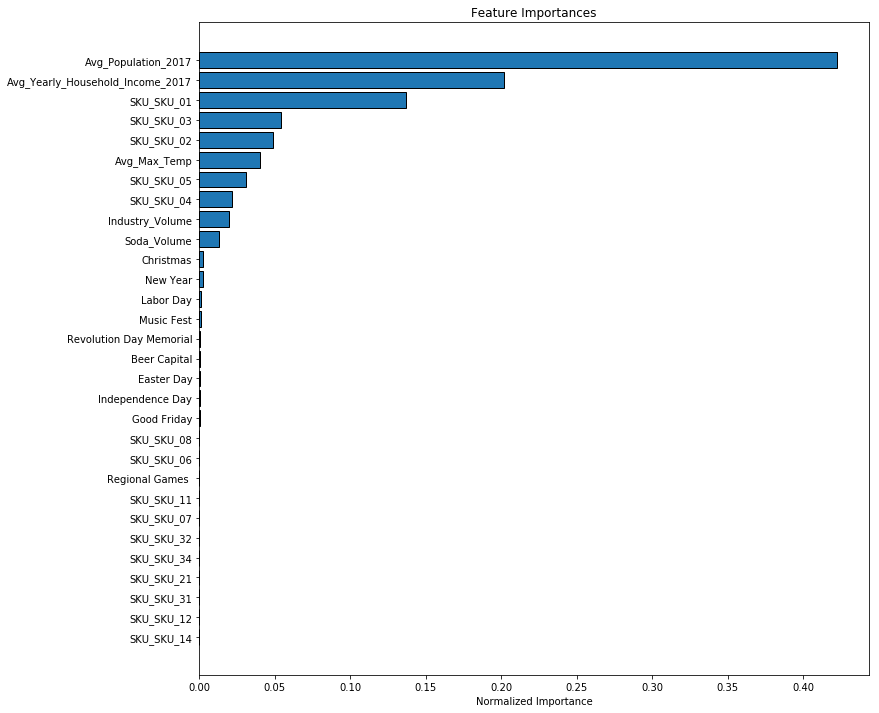

In [43]:
feature_importance = plot_feature_importances(feature_importances,30)

## Predicting The Demand In Volume

In [44]:
# test dataset 
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
# making predictions
pred_test = model_fix.predict(test_df_std[x_call])
test_df.loc[:,'Volume'] = pred_test
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,33.14325,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,7.08000,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,6.90300,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,4.42500,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,21.63825,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [46]:
# function to apply split() to contents of columns 17 and above
def split(x):
    x = x.split('_')
    return x[1]+'_'+x[2]

test_df.loc[:,'SKU'] = test_df[test_df.columns[17:]].idxmax(axis=1).apply(split).values

In [47]:
test_df.drop(columns=test_df.iloc[:,17:-1].columns,inplace=True)
test_df.reset_index(inplace=True)
print(test_df.shape)
test_df.head()

(87000, 19)


,YearMonth,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU
0,2013-01-01,Agency_60,33.14325,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,SKU_34
1,2013-02-01,Agency_60,7.08000,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,SKU_34
2,2013-03-01,Agency_60,6.90300,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,SKU_34
3,2013-04-01,Agency_60,4.42500,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,SKU_34
4,2013-05-01,Agency_60,21.63825,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,SKU_34


In [48]:
pivot = pd.pivot_table(test_df, values='Volume', index='YearMonth', columns=['Agency','SKU'])
print(pivot.shape)
pivot.head()

(60, 1450)


Agency     Agency_01                                                     \
SKU           SKU_01    SKU_02    SKU_03     SKU_04    SKU_05    SKU_06   
YearMonth                                                                 
2013-01-01   78.3000   76.6260  35.80272  199.27215  16.01334  17.93298   
2013-02-01  100.9908   88.5384  46.20852  239.13297  15.35517  27.71484   
2013-03-01  117.4284   99.9972  51.45372  323.41068  29.74545  29.72118   
2013-04-01  124.2648  116.3268  70.50564  268.21425  24.29691  38.92014   
2013-05-01  175.6080  131.1660  65.58192  435.76605  27.11916  49.09440   

Agency                                                                   \
SKU           SKU_07     SKU_08    SKU_11    SKU_12    SKU_14    SKU_15   
YearMonth                                                                 
2013-01-01  17.93298   8.505090   6.64560  17.93298  17.93298  17.93298   
2013-02-01  27.71484   8.943870  10.44552  27.71484  27.71484  27.71484   
2013-03-01  29.72118  14.494650  15.93240  29.72118  29.72118  29.72118   
2013-04-01  38.92014  13.574715  16.83996  38.92014  38.92014  38.92014   
2013-05-01  49.09440  14.345550  19.49376  49.09440  49.09440  49.09440   

Agency                                                                  \
SKU           SKU_17    SKU_18    SKU_20    SKU_21    SKU_22    SKU_23   
YearMonth                                                                
2013-01-01  17.93298  17.93298  17.93298  17.93298  17.93298  17.93298   
2013-02-01  27.71484  27.71484  27.71484  27.71484  27.71484  27.71484   
2013-03-01  29.72118  29.72118  29.72118  29.72118  29.72118  29.72118   
2013-04-01  38.92014  38.92014  38.92014  38.92014  38.92014  38.92014   
2013-05-01  49.09440  49.09440  49.09440  49.09440  49.09440  49.09440   

Agency                                                                  \
SKU           SKU_24    SKU_26    SKU_27    SKU_28    SKU_31    SKU_32   
YearMonth                                                                
2013-01-01  17.93298  17.93298  17.93298  17.93298  17.93298  17.93298   
2013-02-01  27.71484  27.71484  27.71484  27.71484  27.71484  27.71484   
2013-03-01  29.72118  29.72118  29.72118  29.72118  29.72118  29.72118   
2013-04-01  38.92014  38.92014  38.92014  38.92014  38.92014  38.92014   
2013-05-01  49.09440  49.09440  49.09440  49.09440  49.09440  49.09440   

Agency                Agency_02                                         \
SKU           SKU_34     SKU_01       SKU_02       SKU_03       SKU_04   
YearMonth                                                                
2013-01-01  17.93298  6262.8984   8227.31040   9122.65494  4762.990980   
2013-02-01  27.71484  6802.4016   7893.77325   9612.05820  5401.728855   
2013-03-01  29.72118  8661.2775  11509.56000  11580.43050  7410.081900   
2013-04-01  38.92014  9044.7867  11126.38680  10893.18750  5699.426325   
2013-05-01  49.09440  9157.9767  12871.68975  12524.20125  7781.010900   

Agency                                                                      \
SKU              SKU_05     SKU_06     SKU_07      SKU_08 SKU_11    SKU_12   
YearMonth                                                                    
2013-01-01  2403.317310   62.28960   81.90675  174.121110    0.0  54.27750   
2013-02-01  2801.056530   80.88840  106.95225  239.439690    0.0  77.99550   
2013-03-01  3275.181525   66.45735  118.72275  284.745735    0.0  72.39675   
2013-04-01  3143.330325  123.13380  118.23600  241.439670    0.0  97.94250   
2013-05-01  3514.902450   67.35975  124.60800  335.967030    0.0  76.24500   

Agency                                                                        \
SKU            SKU_14     SKU_15     SKU_17     SKU_18     SKU_20     SKU_21   
YearMonth                                                                      
2013-01-01   60.05400   60.05400   60.05400   60.05400   60.05400   60.05400   
2013-02-01   80.37000   80.37000   80.37000   80.37000   80.37000   80.370

## Making Forecasts Using An LSTM Model

In [49]:
# multivariate sequence -> data samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [50]:
dataset = np.array(pivot)
n_steps = 12
X, y = split_sequences(dataset, n_steps)
n_features = X.shape[2]

In [51]:
# split into train and validation data
train_X, train_y = X[:-12, :], y[:-12,:]
val_X, val_y = X[-12:-3, :], y[-12:-3,:]
test_X, test_y = X[-3:, :], y[-3:,:]

In [52]:
# define LSTM model
model = Sequential()
model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(n_steps, n_features),recurrent_dropout=0.2))
model.add(LSTM(512, activation='relu',return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [53]:
# fit model
history = model.fit(train_X, train_y, epochs=712, batch_size=32, verbose=0, shuffle=False,validation_data=(val_X, val_y))

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 1024)          10137600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 512)           3147776   
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 256)           787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1450)              187050    
Total params: 14,457,002
Trainable params: 14,457,002
Non-trainable params: 0
_________________________________________________________________


In [55]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['loss'],
                name="Train",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['val_loss'],
                name="Test",
                line_color='dimgray',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Forecasting Score")
fig.show()

## Testing Model 

In [56]:
# demonstrate prediction
train_yhat = model.predict(train_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(train_y,train_yhat)))

RMSE of training data : 731.551


In [57]:
# demonstrate prediction
val_yhat = model.predict(val_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(val_y,val_yhat)))

RMSE of training data : 662.048


In [58]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("RMSE of testing data : %.3f" % np.sqrt(mean_squared_error(test_y,test_yhat)))

RMSE of testing data : 878.283
